## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
Data1['logCount'] = np.log(Data1['AvgDailyTrafficCount'])

In [3]:
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,logCount
0,-80.278366,40.468606,84.0,4.430817
1,-80.162117,40.384598,95.0,4.553877
2,-80.221205,40.366778,97.0,4.574711
3,-80.142455,40.622084,111.0,4.709530
4,-80.131975,40.544915,125.0,4.828314


In [4]:
Data1.mean(axis=0)

Longitude                -79.981176
Latitude                  40.457091
AvgDailyTrafficCount    6042.008595
logCount                   8.408343
dtype: float64

In [5]:
Data1['logCount'] = Data1['logCount'] - Data1.mean(axis=0)['logCount']

In [6]:
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,logCount
0,-80.278366,40.468606,84.0,-3.977526
1,-80.162117,40.384598,95.0,-3.854466
2,-80.221205,40.366778,97.0,-3.833632
3,-80.142455,40.622084,111.0,-3.698812
4,-80.131975,40.544915,125.0,-3.580029


In [7]:
X = Data1.iloc[:,0:2]
Y = Data1.iloc[:,-1]

### 1)&2)

In [8]:
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
np.random.seed(1)
length_scale = (1., 1.)
kernel = 1.* RBF(length_scale, length_scale_bounds=(1e-2, 1e2)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gpc_rbf = GaussianProcessRegressor(kernel=kernel,random_state=1)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpc_rbf.fit(X, Y)
print gpc_rbf.log_marginal_likelihood_value_
print gpc_rbf.kernel_

-1364.40499295
0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568)


### 3）

In [9]:
h = .01  # step size in the mesh
x_min, x_max = X.iloc[:, 0].min() - 0.1, X.iloc[:, 0].max() + 0.1
y_min, y_max = X.iloc[:, 1].min() - 0.1, X.iloc[:, 1].max() + 0.1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

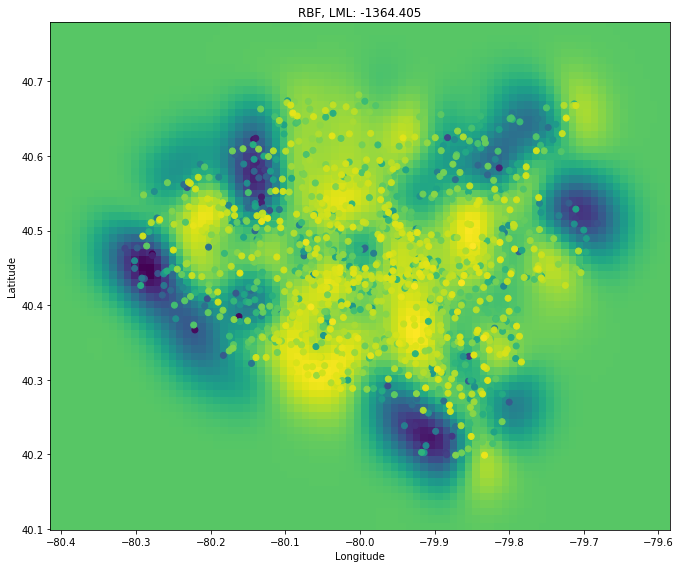

In [10]:
plt.figure(figsize=(10, 8))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
# plt.subplot(1, 1, 1)

# y_mesh_pred, sigma = gp.predict(x_mesh, return_std=True)

Z, sigma = gpc_rbf.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")
# Plot also the training points
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=Y)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gpc_rbf.log_marginal_likelihood(gpc_rbf.kernel_.theta)))

plt.tight_layout()
plt.show()

### 4)

In [11]:
Z, sigma = gpc_rbf.predict(X, return_std=True)

In [12]:
Data1['label'] = (Y > Z + 2*np.std(Z)) * 2 + (Y < Z - 2*np.std(Z)) * 1 

In [13]:
print('%.3f of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts'\
      %(1.0*len(Data1[(Data1['label'] == 1) | (Data1['label'] == 2)]) / len(Data1)))

0.117 of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts


### 5)

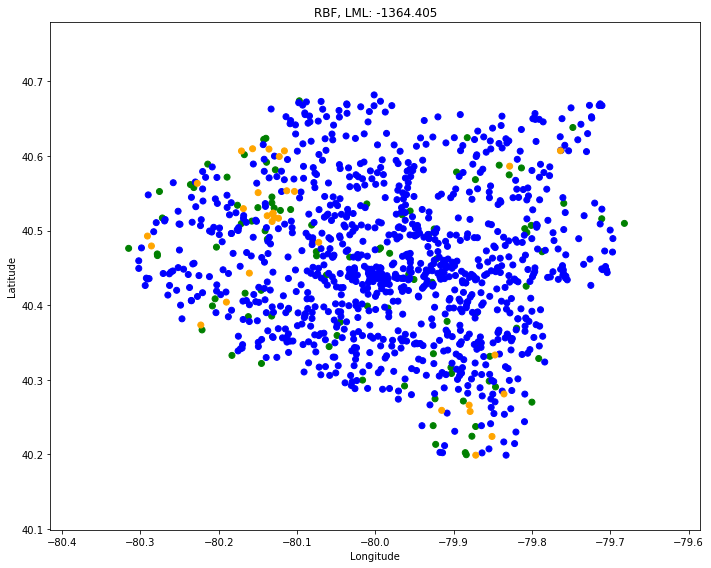

In [14]:
plt.figure(figsize=(10, 8))
# Plot also the training points
labels = ['foo', 'bar', 'baz']
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=np.array(["b", "g", "orange"])[Data1['label'].values])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
# plt.xticks(())
# plt.yticks(())
plt.title("%s, LML: %.3f" %
          ("RBF", gpc_rbf.log_marginal_likelihood(gpc_rbf.kernel_.theta)))

plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly


(35, 2)		Not Anomaly


(15, 19)	Anomaly


(10, 11)	Not Anomaly


Cluster size is 100. Distance from (1,0) to (0,0) is 1. But 2\*sigma = 0.2 which is much smaller than 1. Therefore it is anomaly.

Cluster size is 150. Distance from (35,2) to (35,5) is 3. 2\*sigma = 10 which is larger than 3. Therefore it is not anomaly.

Distance from (15,19) to (15,20) is 1. But cluster size is 2 which is too small. Therefore it is anomaly.

Cluster size is 200. Distance from (10,11) to (10,10) is 1. 2\*sigma = 2 which is larger than 1. Therefore it is not anomaly.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

### Part 1

In [15]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [16]:
Data3 = Data2.copy()

In [17]:
Data2 = Data2.iloc[:,1:].convert_objects(convert_numeric=True).astype(float)

C:\Users\dapangxing\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [18]:
Data2 = Data2.dropna(axis=0)

In [19]:
Data3 = Data3.iloc[Data2.index]

In [20]:
Data2.reset_index(inplace=True, drop=True) 
Data3.reset_index(inplace=True, drop=True) 

In [21]:
Data2.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,19.0,4.4,4.3,9.0,19.0,31.0,7.1,29.0,71.0,15.0,...,18.0,4.3,27.0,13.8,254.0,76.0,12.9,14.0,89.0,42.0
1,16.0,4.1,4.2,9.0,19.0,27.0,7.6,25.0,72.0,15.0,...,20.0,4.5,28.0,12.0,221.0,70.0,13.1,15.0,84.0,37.0
2,26.0,4.9,4.7,12.0,21.0,41.0,5.1,33.0,45.0,12.0,...,38.0,5.3,54.0,8.1,147.0,64.0,12.6,18.0,84.0,35.0
3,22.0,4.8,4.6,12.0,21.0,40.0,7.4,33.0,33.0,14.0,...,27.0,4.3,32.0,9.8,236.0,75.0,12.9,13.0,84.0,46.0
4,21.0,4.6,4.5,7.0,19.0,32.0,8.3,29.0,26.0,14.0,...,24.0,4.1,28.0,8.5,219.0,89.0,12.7,12.0,85.0,59.0


In [22]:
df = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

In [23]:
df['Smokers'] = pd.cut(df["'\% Smokers'"], 5, labels=[0, 1, 2, 3, 4]).cat.codes
df['Obese'] = pd.cut(df["'\% Obese'"], 5, labels=[0, 1, 2, 3, 4]).cat.codes
df['Violent'] = pd.cut(df["'Violent Crime Rate'"], 5, labels=[0, 1, 2, 3, 4]).cat.codes
df['Income'] = pd.cut(df["'80/20 Income Ratio'"], 5, labels=[0, 1, 2, 3, 4]).cat.codes
df['Poverty'] = pd.cut(df["'\% Children in Poverty'"], 5, labels=[0, 1, 2, 3, 4]).cat.codes
df['PM'] = pd.cut(df["'Average Daily PM2.5'"], 5, labels=[0, 1, 2, 3, 4]).cat.codes

C:\Users\dapangxing\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dapangxing\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dapangxing\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [24]:
df.head()

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5',Smokers,Obese,Violent,Income,Poverty,PM
0,19.0,31.0,254.0,4.3,18.0,12.9,1,2,0,1,1,3
1,19.0,27.0,221.0,4.5,20.0,13.1,1,2,0,1,1,3
2,21.0,41.0,147.0,5.3,38.0,12.6,2,4,0,2,3,3
3,21.0,40.0,236.0,4.3,27.0,12.9,2,4,0,1,2,3
4,19.0,32.0,219.0,4.1,24.0,12.7,1,2,0,1,2,3


In [25]:
data = df.loc[:,'Smokers':'PM']

In [26]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())
model = BayesianModel(best_model.edges())
model.fit(data, estimator=MaximumLikelihoodEstimator)

[('Violent', 'Poverty'), ('Poverty', 'Smokers'), ('Poverty', 'Income'), ('Smokers', 'Obese'), ('Smokers', 'PM')]


In [27]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

In [28]:
exmp=data.apply(lambda x: LL(x,model),axis=1)

In [29]:
D1 = pd.DataFrame({'County':Data3.iloc[exmp.sort_values().head(5).index].County,'log-likelihood':exmp.sort_values().head(5).values})
D1

,County,log-likelihood
1444,"New York, New York",-16.608495
182,"San Francisco, California",-14.827149
1577,"Rolette, North Dakota",-14.686742
1007,"Suffolk, Massachusetts",-14.457849
248,"District of Columbia, District of Columbia",-13.671439


### Part 2

In [30]:
X = Data2
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(X)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X))
res.head()

,0,1,2
0,215.546368,554.609617,101.895485
1,108.370262,655.932344,186.335226
2,410.503731,530.643663,282.291939
3,168.209200,602.378878,141.457457
4,105.075152,777.335076,315.009861


In [31]:
# add cluster and distance information for each data record
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
1890,2443.716031,1970.018443,2251.260167,1,1970.018443
1294,2036.147297,1332.735955,1759.249198,1,1332.735955
96,1917.732820,1208.900834,1639.063836,1,1208.900834
2304,1644.876605,1017.910163,1394.632068,1,1017.910163
995,1651.954082,918.374430,1366.737248,1,918.374430


In [32]:
D2 = pd.DataFrame({'County':Data3.iloc[res.sort_values("score",ascending=False)[:5].index].County,'km score':res.sort_values("score",ascending=False)[:5].score})
D2

,County,km score
1890,"Shannon, South Dakota",1970.018443
1294,"St. Louis City, Missouri",1332.735955
96,"Crittenden, Arkansas",1208.900834
2304,"Petersburg City, Virginia",1017.910163
995,"Baltimore City, Maryland",918.374430


In [33]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [34]:
D3 = pd.DataFrame({'County':Data3.iloc[pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5].index].County,'GM score':pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5][0].values})
D3

,County,GM score
1890,"Shannon, South Dakota",-197.420106
66,"Apache, Arizona",-133.042814
1444,"New York, New York",-131.452092
2158,"Willacy, Texas",-129.450559
1577,"Rolette, North Dakota",-126.696033


### Part 3

In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
# fit the model
clf = IsolationForest(max_samples=100, random_state=999)
clf.fit(X)
y_pred = clf.predict(X)

In [37]:
D4 = pd.DataFrame({'County':Data3.iloc[pd.DataFrame(clf.decision_function(X)).sort_values(0)[:5].index].County,'IF score':pd.DataFrame(clf.decision_function(X)).sort_values(0)[:5][0].values})
D4

,County,IF score
1890,"Shannon, South Dakota",-0.137898
66,"Apache, Arizona",-0.092279
1296,"Big Horn, Montana",-0.085660
1577,"Rolette, North Dakota",-0.080971
913,"East Carroll, Louisiana",-0.075939


### Part 4

In [38]:
df_ = D2.merge(D3, on="County", how='outer')
df_ = df_.merge(D4, on="County", how='outer')

In [39]:
df_

,County,km score,GM score,IF score
0,"Shannon, South Dakota",1970.018443,-197.420106,-0.137898
1,"St. Louis City, Missouri",1332.735955,NaN,NaN
2,"Crittenden, Arkansas",1208.900834,NaN,NaN
3,"Petersburg City, Virginia",1017.910163,NaN,NaN
4,"Baltimore City, Maryland",918.374430,NaN,NaN
5,"Apache, Arizona",NaN,-133.042814,-0.092279
6,"New York, New York",NaN,-131.452092,NaN
7,"Willacy, Texas",NaN,-129.450559,NaN
8,"Rolette, North Dakota",NaN,-126.696033,-0.080971
9,"Big Horn, Montana",NaN,NaN,-0.085660


I found that Shannon, South Dakota is identified by all three methods. Apache, Arizona and Rolette, North Dakota are both identified by GM and IF methods.

In [40]:
df = Data3[(Data3['County']=='Shannon, South Dakota')|(Data3['County']=='Apache, Arizona')|(Data3['County']=='Rolette, North Dakota')]

In [41]:
df[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
66,26,33,94,6.3,40,9.8
1577,38,41,29,7.7,41,9.6
1890,41,45,0,6.5,54,11.8


In [42]:
df_mean = Data2.describe()
df_mean[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

,'\% Smokers','\% Obese','Violent Crime Rate','80/20 Income Ratio','\% Children in Poverty','Average Daily PM2.5'
count,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,18.569992,31.022928,267.538616,4.545133,23.844730,11.720072
std,3.646631,4.524278,198.532609,0.695486,8.692791,1.535203
min,7.000000,11.000000,0.000000,2.700000,3.000000,7.200000
25%,16.000000,29.000000,128.000000,4.100000,17.250000,10.600000
50%,18.000000,31.000000,216.000000,4.400000,23.000000,12.000000
75%,21.000000,34.000000,356.750000,4.900000,29.000000,13.000000
max,41.000000,46.000000,1885.000000,8.700000,54.000000,14.900000


By comparing with the mean values. I found that all of the three cities have high percentages of smokers, obese,80/20 income ratio, children in poverty, and low percentages of violent crime rate. The other cities identified as anomalous using three methods are different. This may be because these records all show some different characteristics but not as consistent as the above three counties and are captured by different methods.